In [1]:
# @title Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import hashlib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

# Set seed for reproducibility
SEED = 47
np.random.seed(SEED)
random.seed(SEED)

In [2]:
# @title Load & Preprocess Data
def load_and_preprocess():
    # Load data
    df = pd.read_csv('marketing_campaign.csv', sep='\t')

    # Clean data
    df = df.drop(['ID', 'Z_CostContact', 'Z_Revenue'], axis=1)
    df['Income'] = df['Income'].fillna(df['Income'].median())
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
    latest_date = df['Dt_Customer'].max()
    df['Tenure'] = (latest_date - df['Dt_Customer']).dt.days
    df = df.drop('Dt_Customer', axis=1)

    # One-Hot Encoding
    return pd.get_dummies(df, columns=['Education', 'Marital_Status'])

df = load_and_preprocess()

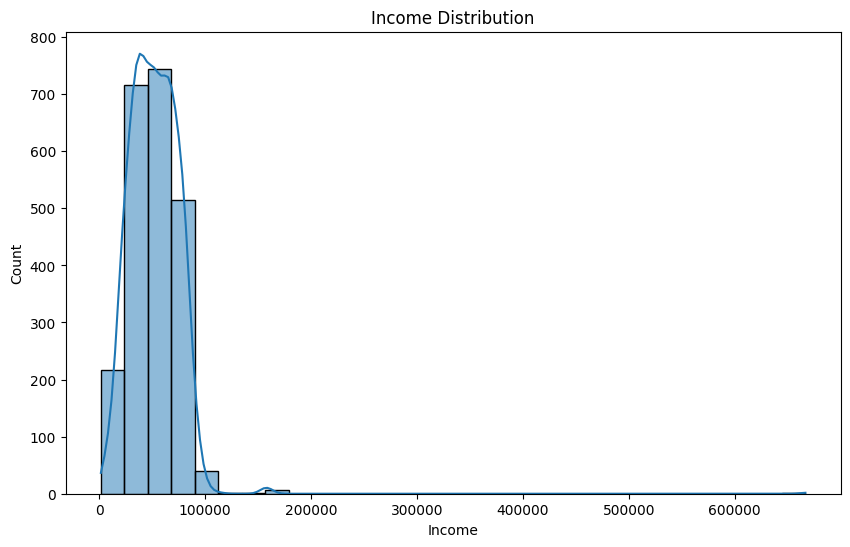

In [3]:
# @title EDA

# Income Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['Income'], bins=30, kde=True)
plt.title('Income Distribution')
plt.show()

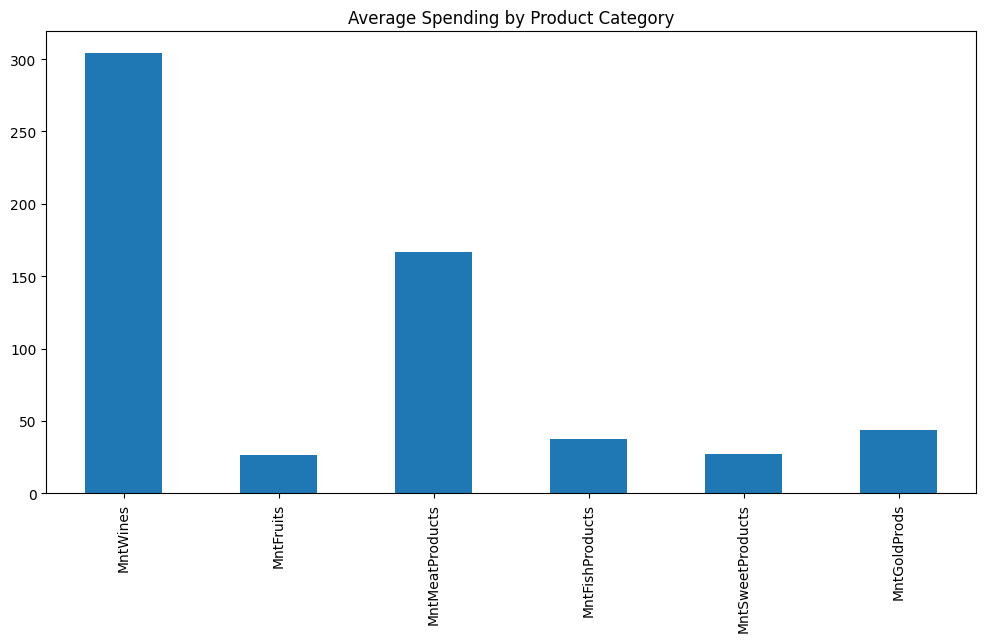

In [4]:
# @title EDA
# Spending Patterns
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
plt.figure(figsize=(12,6))
df[spending_cols].mean().plot(kind='bar')
plt.title('Average Spending by Product Category')
plt.show()

In [5]:
# @title Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)


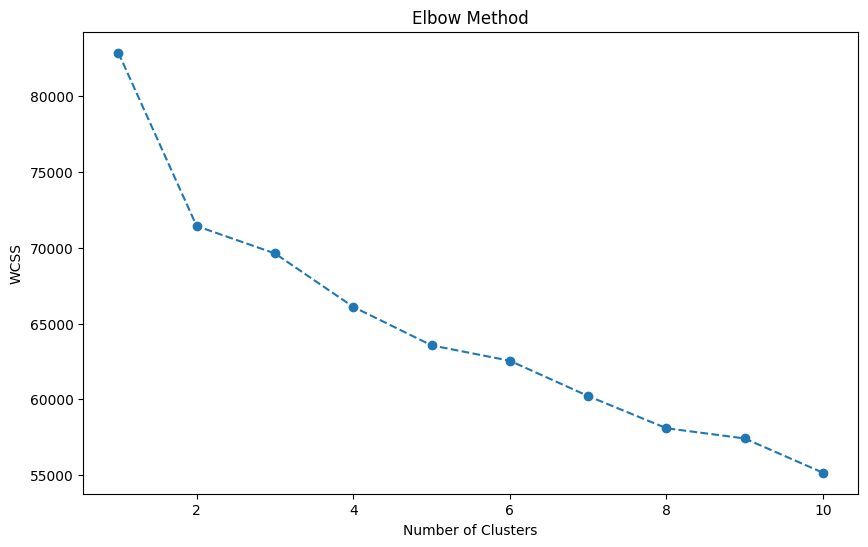

In [6]:
# @title Optimal Cluster Determination with Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

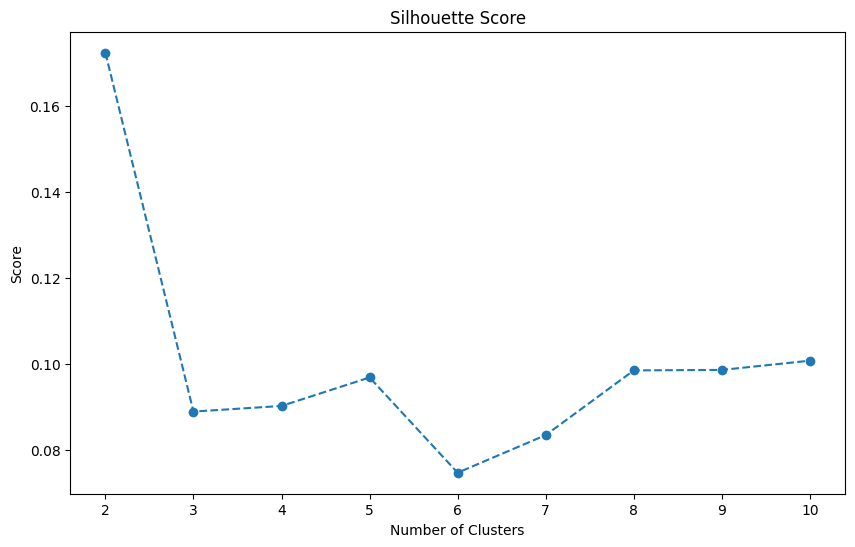

In [7]:
# @title Optimal Cluster Determination with Silhouette Score
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    clusters = kmeans.fit_predict(scaled_df)
    silhouette_scores.append(silhouette_score(scaled_df, clusters))

plt.figure(figsize=(10,6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

K-Means Optimization:


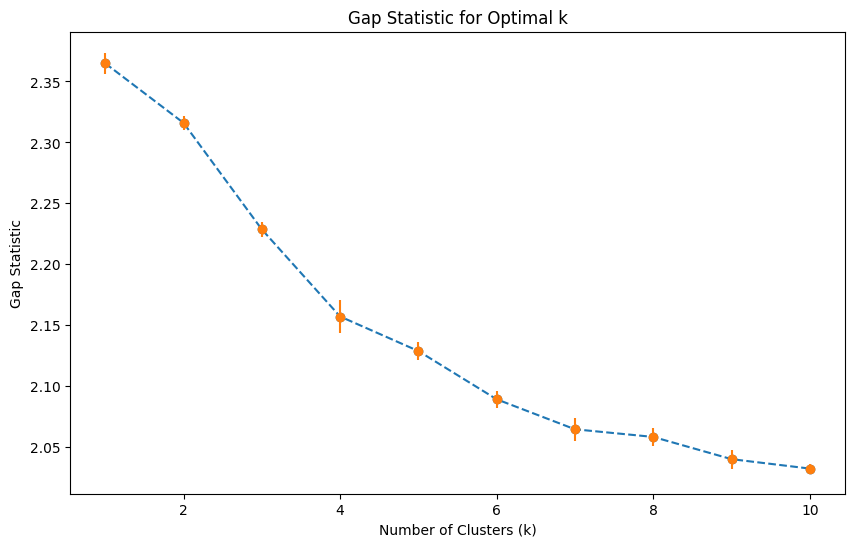

Optimal number of clusters based on Gap Statistic: 1


In [8]:
# @title Optimal Cluster Determination with Gap Statistic
def find_optimal_clusters(scaled_df):
    # K-Means Optimization
    print("K-Means Optimization:")
    wcss, silhouette_scores = [], []
    for i in range(1, 11):
        # Use the imported KMeans class here
        kmeans = KMeans(n_clusters=i, random_state=SEED).fit(scaled_df)
        wcss.append(kmeans.inertia_)
        if i >= 2:
            silhouette_scores.append(silhouette_score(scaled_df, kmeans.labels_))

    # Gap Statistic
    # Manual Implementation of Gap Statistic
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import pairwise_distances
    from sklearn.preprocessing import StandardScaler

    def calculate_gap_statistic(scaled_df, max_k=8, B=10):

        n = scaled_df.shape[0]
        gaps = np.zeros(max_k)
        sds = np.zeros(max_k)

        for k in range(1, max_k + 1):
            # Use the imported KMeans class, refernced with the global keyword
            kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_df)
            orig_Wk = kmeans.inertia_

            ref_Wks = []
            for _ in range(B):
                ref_data = np.random.uniform(low=scaled_df.min(), high=scaled_df.max(), size=scaled_df.shape)
                kmeans_ref = KMeans(n_clusters=k, random_state=0).fit(ref_data)
                ref_Wks.append(kmeans_ref.inertia_)

            gaps[k - 1] = np.mean(np.log(ref_Wks)) - np.log(orig_Wk)
            sds[k - 1] = np.std(np.log(ref_Wks)) * np.sqrt(1 + 1 / B)

        return gaps, sds

    # Scaled data as scaled_df
    max_k = 10
    gaps, sds = calculate_gap_statistic(scaled_df, max_k)

    # Plot the Gap Statistic
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), gaps, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Gap Statistic')
    plt.title('Gap Statistic for Optimal k')
    plt.errorbar(range(1, max_k + 1), gaps, yerr=sds, fmt='o')
    plt.show()

    # Determine the optimal k (where gap(k) > gap(k+1) - s_k+1)
    optimal_k = np.argmax(gaps) + 1
    print(f"Optimal number of clusters based on Gap Statistic: {optimal_k}")

    # Return the optimal number of clusters
    return {'kmeans': {'gap': optimal_k}} # Returning a dictionary with optimal k


# Call the function and assign the result to optimal
optimal = find_optimal_clusters(scaled_df) # Call the function here

In [9]:
# @title Clustering with Stability Testing
def stable_clustering(scaled_df, n_seeds=5):
    results = {}

    # K-Means
    kmeans_results = []
    for seed in range(n_seeds):
        hashed_seed = int(hashlib.sha256(str(seed).encode()).hexdigest(), 16) % 10**8
        kmeans = KMeans(n_clusters=2, random_state=hashed_seed).fit(scaled_df)
        kmeans_results.append(kmeans.labels_)
    results['kmeans'] = kmeans_results

    # DBSCAN
    neighbors = NearestNeighbors(n_neighbors=5).fit(scaled_df)
    distances = np.sort(neighbors.kneighbors(scaled_df)[0][:, -1])
    eps = distances[np.argmax(np.diff(distances)) + 1]
    dbscan = DBSCAN(eps=eps, min_samples=5).fit(scaled_df)
    results['dbscan'] = [dbscan.labels_]  # DBSCAN is deterministic

    # Hierarchical
    agg_results = []
    for seed in range(n_seeds):
        hashed_seed = int(hashlib.sha256(str(seed).encode()).hexdigest(), 16) % 10**8
        agg = AgglomerativeClustering(n_clusters=2).fit(scaled_df)
        agg_results.append(agg.labels_)
    results['hierarchical'] = agg_results

    return results

cluster_results = stable_clustering(scaled_df)

# Cluster Stability Analysis
def calculate_stability(results):
    stability = {}
    for method, labels_list in results.items():
        scores = []
        for i in range(len(labels_list)-1):
            scores.append(adjusted_rand_score(labels_list[i], labels_list[i+1]))
        stability[method] = np.mean(scores)
    return stability

stability_scores = calculate_stability(cluster_results)
print("\nCluster Stability Scores:")
for method, score in stability_scores.items():
    print(f"{method.capitalize()}: {score:.3f}")


Cluster Stability Scores:
Kmeans: 0.992
Dbscan: nan
Hierarchical: 1.000


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [10]:
# @title Silhouette score for two cluster analysis

from sklearn.metrics import silhouette_score

# Calculate Silhouette Score for K-Means with 2 clusters
kmeans_3 = KMeans(n_clusters=2, init='k-means++', random_state=42)
kmeans_clusters_3 = kmeans_3.fit_predict(scaled_df)
silhouette_avg_3 = silhouette_score(scaled_df, kmeans_clusters_3)

# Calculate Silhouette Score for DBSCAN
dbscan = DBSCAN(eps=3, min_samples=5)  # Example parameters, adjust as needed
dbscan_clusters = dbscan.fit_predict(scaled_df)
silhouette_avg_dbscan = silhouette_score(scaled_df, dbscan_clusters)


# Calculate Silhouette Score for Agglomerative Clustering with 2 clusters
agg_clustering_3 = AgglomerativeClustering(n_clusters=2, linkage='complete')
agg_clusters_3 = agg_clustering_3.fit_predict(scaled_df)
silhouette_avg_agg_3 = silhouette_score(scaled_df, agg_clusters_3)

# Print the silhouette scores
print("Silhouette Score for K-Means (2 clusters):", silhouette_avg_3)
print("Silhouette Score for DBSCAN:", silhouette_avg_dbscan)
print("Silhouette Score for Agglomerative Clustering (2 clusters):", silhouette_avg_agg_3)

Silhouette Score for K-Means (2 clusters): 0.17227817680207946
Silhouette Score for DBSCAN: -0.04501776218458275
Silhouette Score for Agglomerative Clustering (2 clusters): 0.7700600100958181


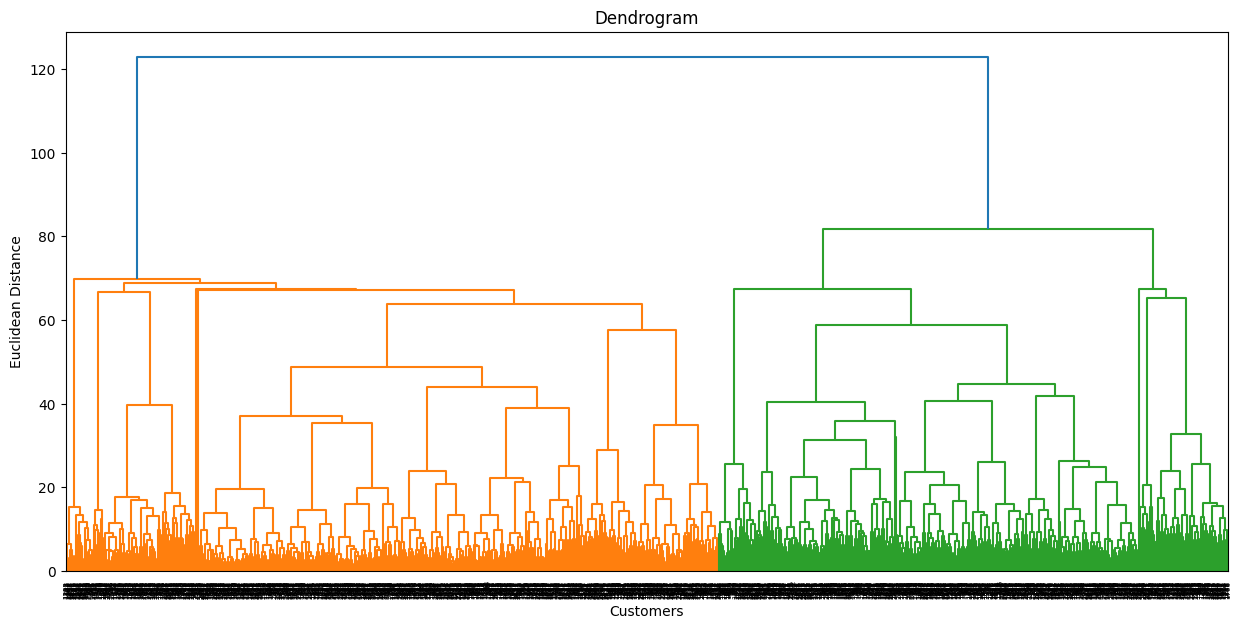

In [11]:
# @title Hierarchical Clustering (Agglomerative Clustering)
# Dendrogram
plt.figure(figsize=(15, 7))
dend = dendrogram(linkage(scaled_df, method='ward'))  # Linkage method is 'ward' here
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()

# Agglomerative Clustering
# If using scikit-learn version < 1.2, remove affinity='euclidean'
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='complete')
agg_clusters = agg_clustering.fit_predict(scaled_df)
df['Hierarchical_Cluster'] = agg_clusters

In [12]:
# @title Cluster Characterization
def characterize_clusters(labels, method_name):
    df[f'{method_name}_Cluster'] = labels
    # Exclude the cluster label column from the mean calculation
    cluster_profile = df.drop(columns=[col for col in df.columns if '_Label' in col]).groupby(f'{method_name}_Cluster').mean()

    print(f"\n{method_name.capitalize()} Cluster Profiles:")
    print(cluster_profile[['Income', 'MntWines', 'MntMeatProducts',
                          'NumDealsPurchases', 'NumWebPurchases']])

    # Assign labels based on characteristics
    if method_name == 'kmeans':
        labels_map = {
            0: "High-Value Customers", #Big Spenders
            1: "Low-Value Customers", #Budget-Conscious Shoppers (4 cluster)"Premium Customers",
            #2: "Deal Seekers",
            #3: "Regular Shoppers"
        }
        df[f'{method_name}_Cluster_Label'] = df[f'{method_name}_Cluster'].map(labels_map)

    return cluster_profile

# Characterize all methods
for method in cluster_results.keys():
    characterize_clusters(cluster_results[method][0], method)


Kmeans Cluster Profiles:
                      Income    MntWines  MntMeatProducts  NumDealsPurchases  \
kmeans_Cluster                                                                 
0               72139.621041  606.830317       364.652715           1.988688   
1               39263.746313  106.473451        38.064159           2.544248   

                NumWebPurchases  
kmeans_Cluster                   
0                      5.788462  
1                      2.974189  

Dbscan Cluster Profiles:
                      Income    MntWines  MntMeatProducts  NumDealsPurchases  \
dbscan_Cluster                                                                 
-1              53280.285714  272.714286       114.857143           3.571429   
 0              52234.708016  304.033587       167.113300           2.321093   

                NumWebPurchases  
dbscan_Cluster                   
-1                     5.142857  
 0                     4.081505  

Hierarchical Cluster Profiles:
  

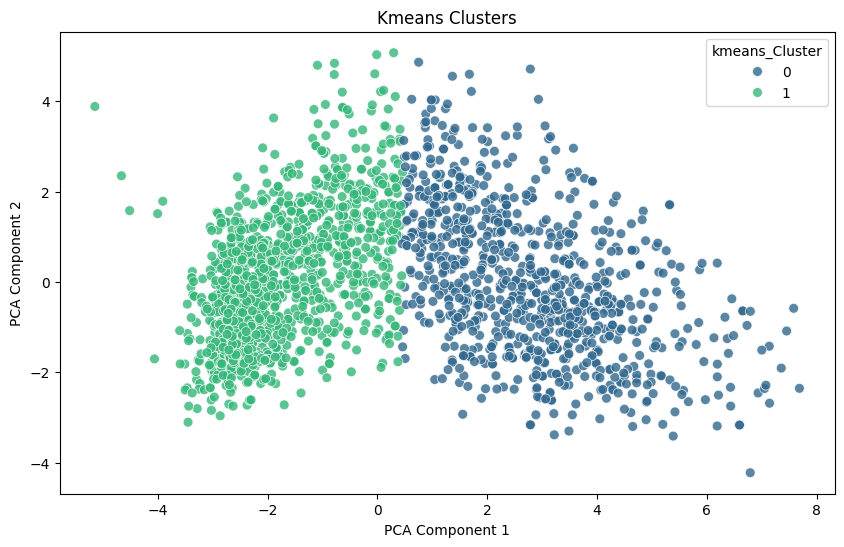

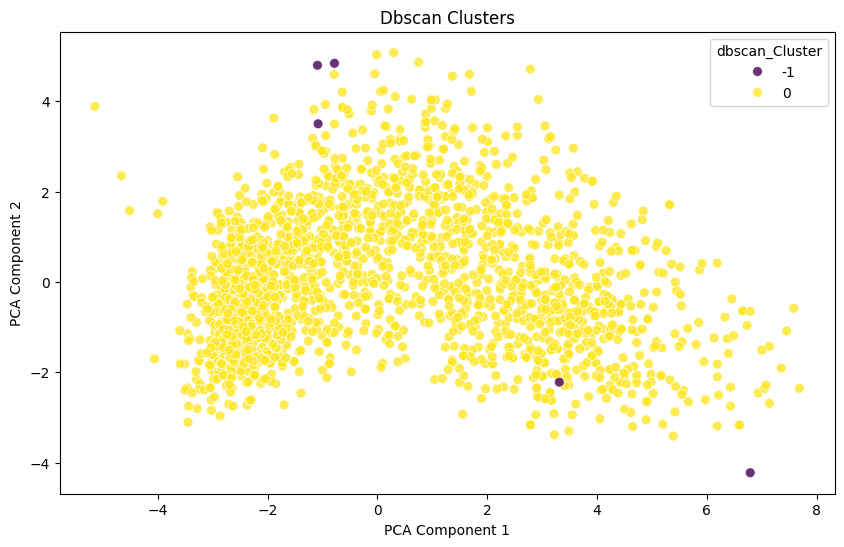

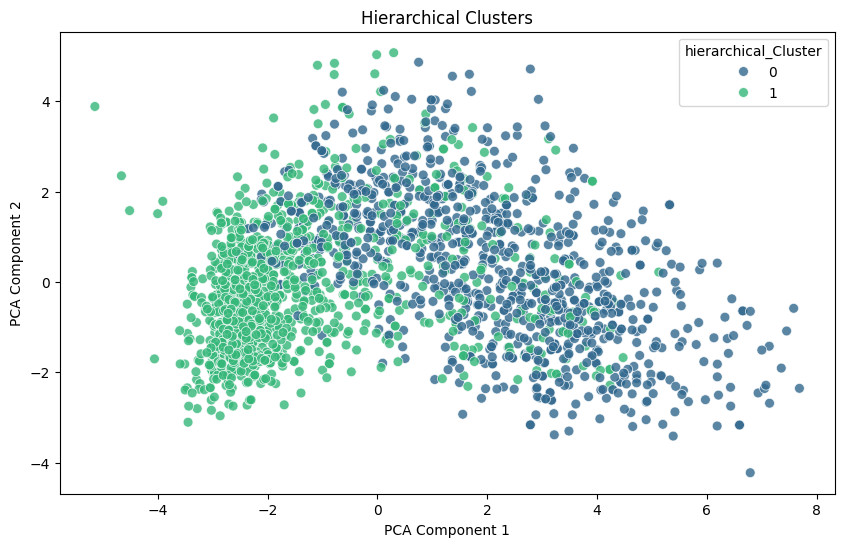

In [13]:
# @title Cluster Visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_df)

def plot_clusters(method_name):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1],
                    hue=df[f'{method_name}_Cluster'], palette='viridis',
                    s=50, alpha=0.8)
    plt.title(f'{method_name.capitalize()} Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

for method in cluster_results.keys():
    plot_clusters(method)

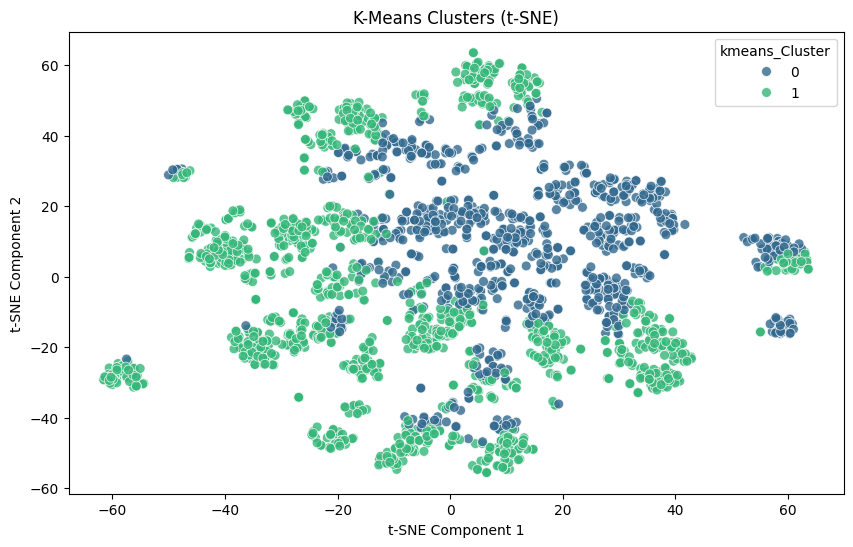

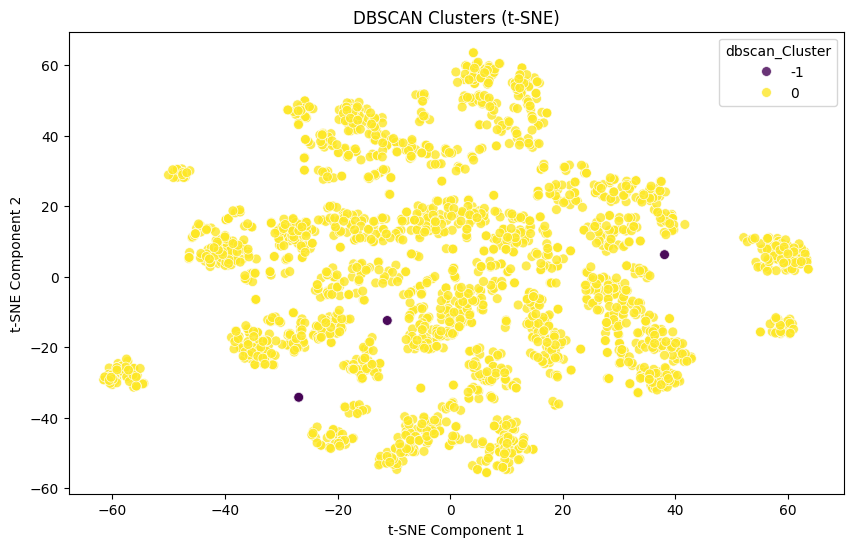

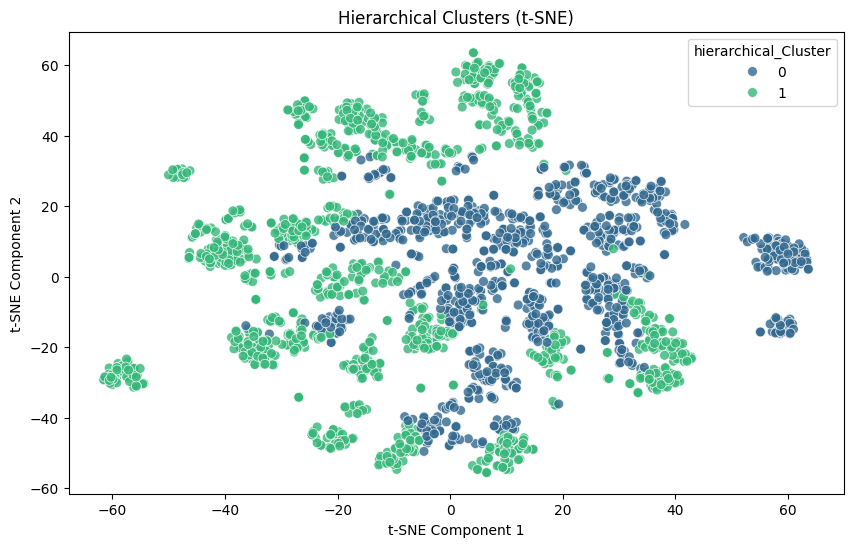

In [14]:
# @title TSNE for all the three cluster algorithms

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE for each clustering method
tsne = TSNE(n_components=2, random_state=SEED)

# K-Means
kmeans_tsne = tsne.fit_transform(scaled_df)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=kmeans_tsne[:, 0], y=kmeans_tsne[:, 1],
                hue=df['kmeans_Cluster'], palette='viridis',
                s=50, alpha=0.8)
plt.title('K-Means Clusters (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# DBSCAN
dbscan_tsne = tsne.fit_transform(scaled_df)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dbscan_tsne[:, 0], y=dbscan_tsne[:, 1],
                hue=df['dbscan_Cluster'], palette='viridis',
                s=50, alpha=0.8)
plt.title('DBSCAN Clusters (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Hierarchical
hierarchical_tsne = tsne.fit_transform(scaled_df)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=hierarchical_tsne[:, 0], y=hierarchical_tsne[:, 1],
                hue=df['hierarchical_Cluster'], palette='viridis',
                s=50, alpha=0.8)
plt.title('Hierarchical Clusters (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [15]:
# @title Cluster Distribution Labels
print("\n Cluster Distributions:")
for method in cluster_results.keys():
    if f'{method}_Cluster_Label' in df.columns:
        print(f"\n{method.capitalize()} Clusters:")
        print(df[f'{method}_Cluster_Label'].value_counts())


 Cluster Distributions:

Kmeans Clusters:
kmeans_Cluster_Label
Low-Value Customers     1356
High-Value Customers     884
Name: count, dtype: int64


In [16]:
# @title Fine tune all the three cluster algorithms.

import numpy as np
# @title Fine-tuning Clustering Algorithms
def fine_tune_kmeans(scaled_df):
    """Fine-tunes KMeans clustering."""
    best_score = -1
    best_kmeans = None
    for n_clusters in range(2, 6):  # Try different numbers of clusters
        for init in ['k-means++', 'random']:  # Try different initialization methods
            for max_iter in [300, 500]:  # Try different maximum iterations
                kmeans = KMeans(n_clusters=n_clusters, init=init, max_iter=max_iter, random_state=SEED)
                kmeans_labels = kmeans.fit_predict(scaled_df)
                silhouette_avg = silhouette_score(scaled_df, kmeans_labels)
                if silhouette_avg > best_score:
                    best_score = silhouette_avg
                    best_kmeans = kmeans
    return best_kmeans

def fine_tune_dbscan(scaled_df):
    """Fine-tunes DBSCAN clustering."""
    best_score = -1
    best_dbscan = None
    for eps in np.linspace(0.5, 5, 10):  # Try different epsilon values
        for min_samples in range(5, 15):  # Try different minimum samples
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(scaled_df)
            if len(set(dbscan_labels)) > 1:  # Ensure more than one cluster is found
                silhouette_avg = silhouette_score(scaled_df, dbscan_labels)
                if silhouette_avg > best_score:
                    best_score = silhouette_avg
                    best_dbscan = dbscan
    return best_dbscan

def fine_tune_hierarchical(scaled_df):
    """Fine-tunes Hierarchical clustering."""
    best_score = -1
    best_agg = None
    for n_clusters in range(2, 6):  # Try different numbers of clusters
        for linkage in ['ward', 'complete', 'average']:  # Try different linkage methods
            agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
            agg_labels = agg.fit_predict(scaled_df)
            silhouette_avg = silhouette_score(scaled_df, agg_labels)
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_agg = agg
    return best_agg


# Fine-tune the clustering algorithms
best_kmeans = fine_tune_kmeans(scaled_df)
best_dbscan = fine_tune_dbscan(scaled_df)
best_agg = fine_tune_hierarchical(scaled_df)

# Use the best models for clustering
kmeans_labels = best_kmeans.fit_predict(scaled_df)
dbscan_labels = best_dbscan.fit_predict(scaled_df)
agg_labels = best_agg.fit_predict(scaled_df)

# Evaluate and analyze the results of the fine-tuned models
print("KMeans Silhouette Score:", silhouette_score(scaled_df, kmeans_labels))
print("DBSCAN Silhouette Score:", silhouette_score(scaled_df, dbscan_labels))
print("Hierarchical Silhouette Score:", silhouette_score(scaled_df, agg_labels))




KMeans Silhouette Score: 0.7668834329264251
DBSCAN Silhouette Score: 0.16601099180507803
Hierarchical Silhouette Score: 0.7700600100958181


In [17]:
# @title Cluster Characterization (Fine-Tuned Models)
def characterize_clusters_tuned(labels, method_name, scaled_df):
    df[f'{method_name}_Cluster'] = labels
    # Select only numeric columns for the mean calculation
    numeric_cols = df.select_dtypes(include=np.number).columns
    cluster_profile = df.groupby(f'{method_name}_Cluster')[numeric_cols].mean()
    print(f"\n{method_name.capitalize()} Cluster Profiles:")
    print(cluster_profile[['Income', 'MntWines', 'MntMeatProducts',
                          'NumDealsPurchases', 'NumWebPurchases']])
    return cluster_profile

# Characterize fine-tuned models
characterize_clusters_tuned(kmeans_labels, 'kmeans_tuned', scaled_df)
characterize_clusters_tuned(dbscan_labels, 'dbscan_tuned', scaled_df)
characterize_clusters_tuned(agg_labels, 'hierarchical_tuned', scaled_df)



Kmeans_tuned Cluster Profiles:
                            Income    MntWines  MntMeatProducts  \
kmeans_tuned_Cluster                                              
0                     52241.376676  303.919571       167.054513   
1                     48432.000000  322.000000        50.000000   

                      NumDealsPurchases  NumWebPurchases  
kmeans_tuned_Cluster                                      
0                              2.322609         4.082216  
1                              5.000000         7.000000  

Dbscan_tuned Cluster Profiles:
                            Income    MntWines  MntMeatProducts  \
dbscan_tuned_Cluster                                              
-1                    75534.847170  694.124528       396.860377   
 0                    49932.782644  258.624933       141.220312   
 1                    19999.423077    3.076923         9.076923   
 2                    51180.129630  282.537037       100.222222   
 3                    33465.6

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Complain,Response,Tenure,Hierarchical_Cluster,kmeans_Cluster,dbscan_Cluster,hierarchical_Cluster,kmeans_tuned_Cluster,dbscan_tuned_Cluster,hierarchical_tuned_Cluster
hierarchical_tuned_Cluster,,,,,,,,,,,,,,,,,,,,,
0,1968.800268,52219.988382,0.444593,0.506702,49.105898,303.889634,26.250223,166.819929,37.375335,27.059875,...,0.009383,0.148794,353.57328,0.0,0.605898,-0.002234,0.562109,0.000894,-0.035299,0.0
1,1975.000000,72365.500000,0.000000,0.000000,53.000000,355.500000,84.500000,312.500000,205.500000,30.500000,...,0.000000,0.500000,363.50000,1.0,0.000000,-1.000000,0.000000,0.000000,-1.000000,1.0


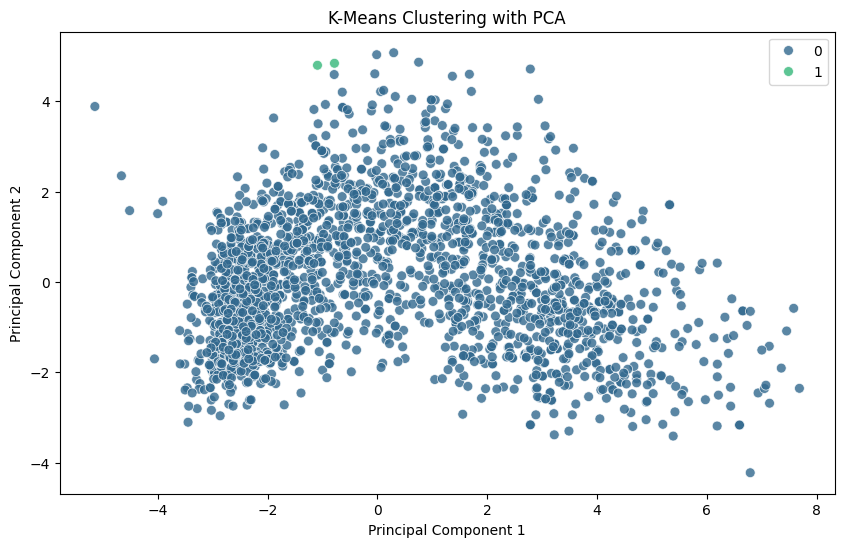

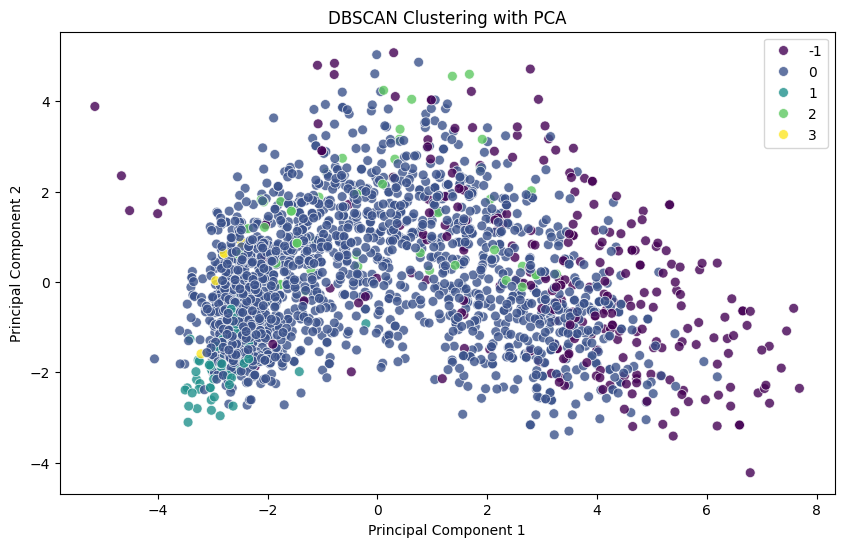

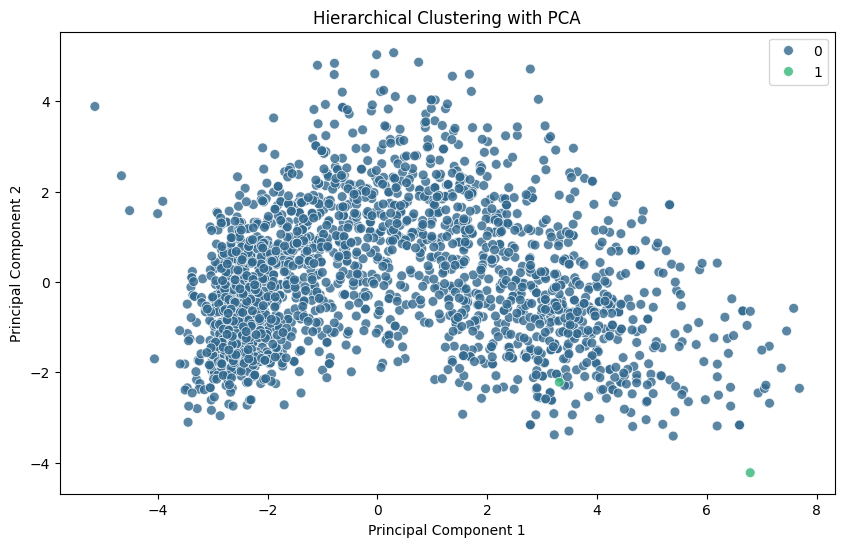

In [18]:
# prompt: Visualize the three Cluster algorithms

import matplotlib.pyplot as plt
# @title Visualize Clusters

def plot_clusters_pca(df, labels, method_name, title):
    """Plots clusters using PCA for dimensionality reduction."""
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(df)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1],
                    hue=labels, palette='viridis', s=50, alpha=0.8)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Assuming you have the labels for each method
plot_clusters_pca(scaled_df, kmeans_labels, 'K-Means', 'K-Means Clustering with PCA')
plot_clusters_pca(scaled_df, dbscan_labels, 'DBSCAN', 'DBSCAN Clustering with PCA')
plot_clusters_pca(scaled_df, agg_labels, 'Hierarchical', 'Hierarchical Clustering with PCA')


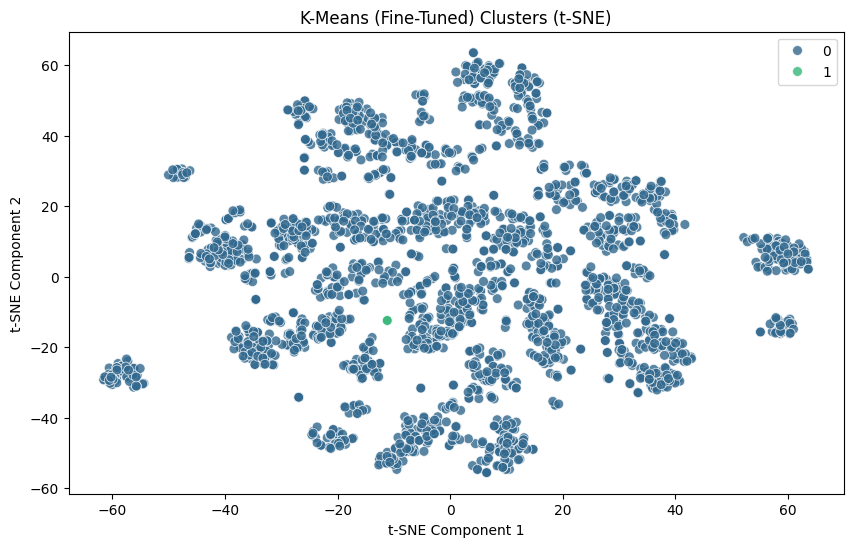

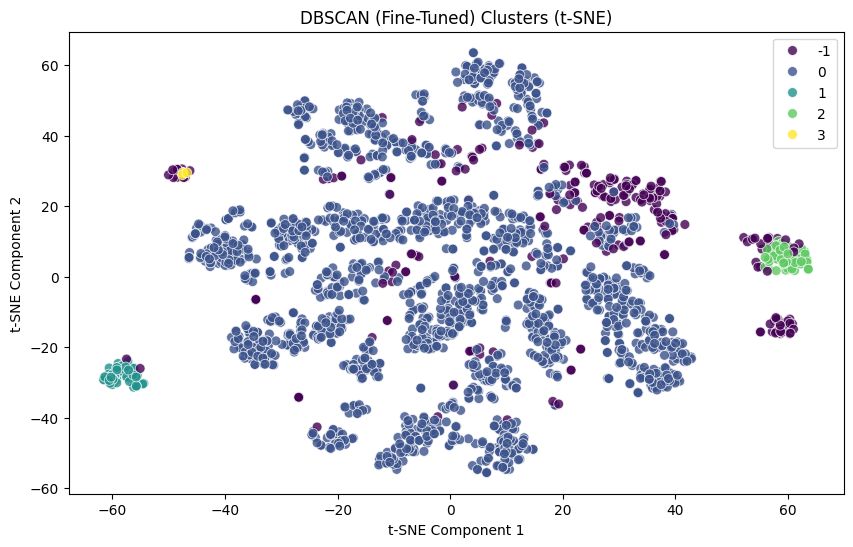

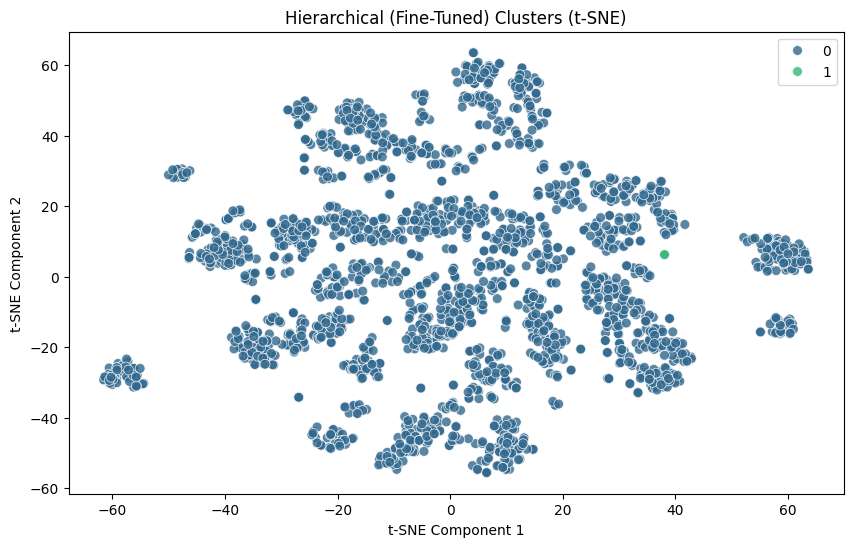

In [19]:
# @title TSNE for all the three fine tuned cluster algorithm

import matplotlib.pyplot as plt
# Perform t-SNE for each fine-tuned clustering method
tsne = TSNE(n_components=2, random_state=SEED)

# K-Means (Fine-tuned)
kmeans_tuned_tsne = tsne.fit_transform(scaled_df)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=kmeans_tuned_tsne[:, 0], y=kmeans_tuned_tsne[:, 1],
                hue=kmeans_labels, palette='viridis',
                s=50, alpha=0.8)
plt.title('K-Means (Fine-Tuned) Clusters (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# DBSCAN (Fine-tuned)
dbscan_tuned_tsne = tsne.fit_transform(scaled_df)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dbscan_tuned_tsne[:, 0], y=dbscan_tuned_tsne[:, 1],
                hue=dbscan_labels, palette='viridis',
                s=50, alpha=0.8)
plt.title('DBSCAN (Fine-Tuned) Clusters (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Hierarchical (Fine-tuned)
hierarchical_tuned_tsne = tsne.fit_transform(scaled_df)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=hierarchical_tuned_tsne[:, 0], y=hierarchical_tuned_tsne[:, 1],
                hue=agg_labels, palette='viridis',
                s=50, alpha=0.8)
plt.title('Hierarchical (Fine-Tuned) Clusters (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()



Kmeans Cluster Labels:


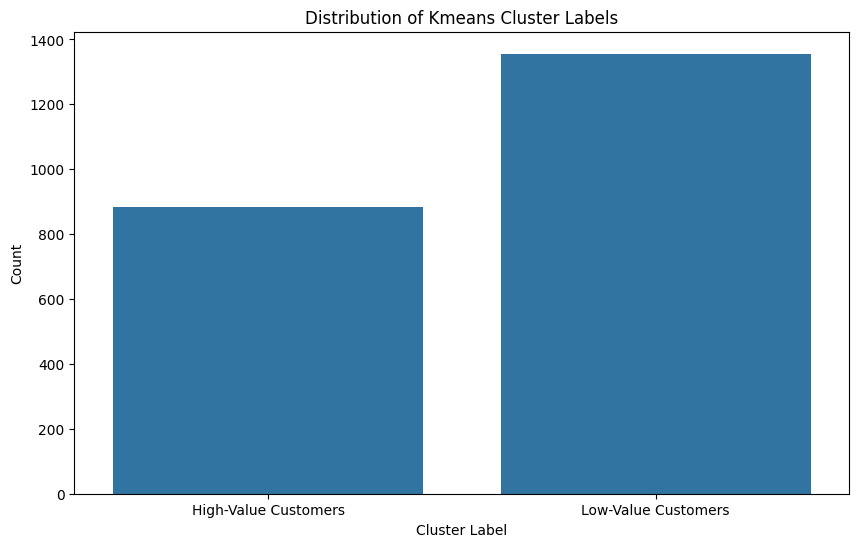

kmeans_Cluster_Label
Low-Value Customers     1356
High-Value Customers     884
Name: count, dtype: int64


In [20]:
# @title Cluster Distributions and Labels

import matplotlib.pyplot as plt
# Assuming df is your DataFrame and cluster_results contains the labels for each method

def plot_cluster_distribution_labels(method_name):
  """Plots the distribution of cluster labels for a given clustering method."""
  if f'{method_name}_Cluster_Label' in df.columns:
    print(f"\n{method_name.capitalize()} Cluster Labels:")
    plt.figure(figsize=(10, 6))
    sns.countplot(x=f'{method_name}_Cluster_Label', data=df)
    plt.title(f'Distribution of {method_name.capitalize()} Cluster Labels')
    plt.xlabel('Cluster Label')
    plt.ylabel('Count')
    plt.show()
    print(df[f'{method_name}_Cluster_Label'].value_counts())

# Plot cluster distributions and labels for KMeans
plot_cluster_distribution_labels('kmeans')

# Plot cluster distributions and labels for DBSCAN
plot_cluster_distribution_labels('dbscan')

# Plot cluster distributions and labels for Hierarchical
plot_cluster_distribution_labels('hierarchical')


In [21]:
# @title Save the Results
# Save the clustered data to a new CSV file
df.to_csv('clustered_data.csv', index=False)

print("Clustered data saved to 'clustered_data.csv'.")

Clustered data saved to 'clustered_data.csv'.
